# Forecasting Bitcoin price

Bitcoin, well known for it's extreme volatility and frequent short-term price fluctuations. These rapid changes can offer opportunities for short-term traders, they often introduce noise that can obscure the broader trends crucial for long-term forecasting. This notebook is made to identify and analyze these long-term trends in Bitcoin prices, filtering out the noise to provide more reliable and stable forecasts in the long-run

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import websocket
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

##  Getting Data from Binance API

In [4]:
import requests
import pandas as pd
from datetime import datetime

url = "https://api.binance.com/api/v3/klines"

start_date_str = "2017-09-01"
end_date_str = "2024-08-01"

#input must be in millseconds)
start_time = int(datetime.strptime(start_date_str, "%Y-%m-%d").timestamp() * 1000)
end_time = int(datetime.strptime(end_date_str, "%Y-%m-%d").timestamp() * 1000)

df = pd.DataFrame(columns=[
    'timestamp', 'open', 'high', 'low', 'close', 'volume', 
    'close_time', 'quote_asset_volume', 'number_of_trades', 
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
])

while start_time < end_time:
    params = {
        "symbol": "BTCUSDT",
        "interval": "1h",  # Change this to the desired interval
        "startTime": start_time,
        "endTime": end_time,
        "limit": 1000
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        
        if not data:
            break
        
        temp_df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume', 
            'close_time', 'quote_asset_volume', 'number_of_trades', 
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        
        df = pd.concat([df, temp_df], ignore_index=True)

        #Acesses the lastest closing time stamp and adds one
        start_time = data[-1][6] + 1

        # If less than 1000 data points are returned, stop the loop
        if len(data) < 1000:
            break
    else:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        break

# Convert the timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Display the resulting DataFrame
print(df)


                               open            high             low  \
timestamp                                                             
2017-08-31 17:00:00   4684.98000000   4684.98000000   4638.98000000   
2017-08-31 18:00:00   4683.90000000   4717.45000000   4650.56000000   
2017-08-31 19:00:00   4703.02000000   4745.42000000   4678.78000000   
2017-08-31 20:00:00   4688.47000000   4717.42000000   4673.10000000   
2017-08-31 21:00:00   4685.50000000   4724.71000000   4666.84000000   
...                             ...             ...             ...   
2024-07-31 13:00:00  66153.82000000  66849.24000000  66136.00000000   
2024-07-31 14:00:00  66508.01000000  66733.02000000  65963.25000000   
2024-07-31 15:00:00  66440.01000000  66560.01000000  66326.00000000   
2024-07-31 16:00:00  66379.99000000  66751.32000000  66287.87000000   
2024-07-31 17:00:00  66362.01000000  66836.30000000  66303.84000000   

                              close         volume     close_time  \
timesta

## Formatting Data Frame for more intrepretable columns

In [6]:
df.rename(columns={'volume': 'volume(BTC)'}, inplace=True)
df.columns = df.columns.str.title()

#We will be using beginning time stamps for forecast so Close_Time not needed and not important as crypto market open 24/7

In [7]:
df = df.drop(['Close_Time'], axis=1)

In [8]:
#Bitcoin data for Open,High,Low,Close is 2 d.p the rest of the zeros don't matter
#As all the columns are numeric we have to convert from object to numeric
df = df.apply(pd.to_numeric)

In [9]:
# No need for Ignore column
df =df.drop(['Ignore'],axis=1)

In [10]:
df

,Open,High,Low,Close,Volume(Btc),Quote_Asset_Volume,Number_Of_Trades,Taker_Buy_Base_Asset_Volume,Taker_Buy_Quote_Asset_Volume
timestamp,,,,,,,,,
2017-08-31 17:00:00,4684.98,4684.98,4638.98,4650.55,7.159727,3.342711e+04,106,4.746056,2.220585e+04
2017-08-31 18:00:00,4683.90,4717.45,4650.56,4700.13,18.489213,8.673195e+04,161,4.510828,2.116925e+04
2017-08-31 19:00:00,4703.02,4745.42,4678.78,4698.77,24.883439,1.169091e+05,170,8.970462,4.222528e+04
2017-08-31 20:00:00,4688.47,4717.42,4673.10,4673.14,13.148827,6.179060e+04,95,0.131131,6.161544e+02
2017-08-31 21:00:00,4685.50,4724.71,4666.84,4724.71,16.740692,7.858542e+04,132,3.484227,1.638903e+04
...,...,...,...,...,...,...,...,...,...
2024-07-31 13:00:00,66153.82,66849.24,66136.00,66508.00,1327.058830,8.835338e+07,94270,670.266040,4.461400e+07
2024-07-31 14:00:00,66508.01,66733.02,65963.25,66440.00,1822.664590,1.209446e+08,107056,926.627740,6.149553e+07
2024-07-31 15:00:00,66440.01,66560.01,66326.00,66379.99,663.878160,4.411274e+07,54158,359.295550,2.387566e+07


In [11]:
df.describe()
'''
Can see number of trades( and volume at certain periods are zero
Indicating maintainece break or some sort of restirction on buying
'''


'\nCan see number of trades( and volume at certain periods are zero\nIndicating maintainece break or some sort of restirction on buying\n'

In [12]:
df[df['Volume(Btc)']==0]
#Searching these dates up confirms that this is due to maintainece breaks

,Open,High,Low,Close,Volume(Btc),Quote_Asset_Volume,Number_Of_Trades,Taker_Buy_Base_Asset_Volume,Taker_Buy_Quote_Asset_Volume
timestamp,,,,,,,,,
2017-09-06 16:00:00,4619.43,4619.43,4619.43,4619.43,0.0,0.0,0,0.0,0.0
2019-06-07 21:00:00,7930.85,7930.85,7930.85,7930.85,0.0,0.0,0,0.0,0.0
2021-02-11 03:00:00,44582.07,44582.07,44582.07,44582.07,0.0,0.0,0,0.0,0.0
2023-03-24 12:00:00,28080.00,28080.00,28080.00,28080.00,0.0,0.0,0,0.0,0.0


In [13]:
'''
- We can get rid of Taker_Buy_Base_Asset_Volume as it also measures volume and little information is to be gained (corr = 0.997)
- We will remove Taker_Buy_Quote_Asset_Volume as only accounts for buying an not selling
- Number of trades and volume are closely related, however can give a sign of whale activity(which could be indication for price so I will keep it)
'''

df.corr()['Volume(Btc)'] 


Open                           -0.015510
High                           -0.013634
Low                            -0.018042
Close                          -0.015713
Volume(Btc)                     1.000000
Quote_Asset_Volume              0.869048
Number_Of_Trades                0.899745
Taker_Buy_Base_Asset_Volume     0.997145
Taker_Buy_Quote_Asset_Volume    0.867785
Name: Volume(Btc), dtype: float64

In [14]:
df = df.drop(['Taker_Buy_Quote_Asset_Volume','Taker_Buy_Base_Asset_Volume'],axis=1)

In [15]:
df.rename(columns={"Quote_Asset_Volume":"Volume(USDT)"},inplace=True)

## Invesitgating Price
In the highly volatile cryptocurrency markets, prices often experience brief and extreme fluctuations that can introduce noise into our data. My approach is more on modeling the overall trend and forecasting long term trends rather than capturing all the fluctuations

- Removing High and Low Columns: The High and Low columns primarily capture these extreme values, which are often just noise, as prices may be in rough region for only a few minutes or even seconds!

- Averaging Open and Close Prices: By averaging the Open and Close prices, To further smooth out short-term volatility and focus on the general price trend.

In [17]:
df['Average_price']=(df['Open']+df['High'])/2


In [18]:
df.drop(df.iloc[:, :4].columns, axis=1, inplace=True)


Text(0.5, 0, 'Years')

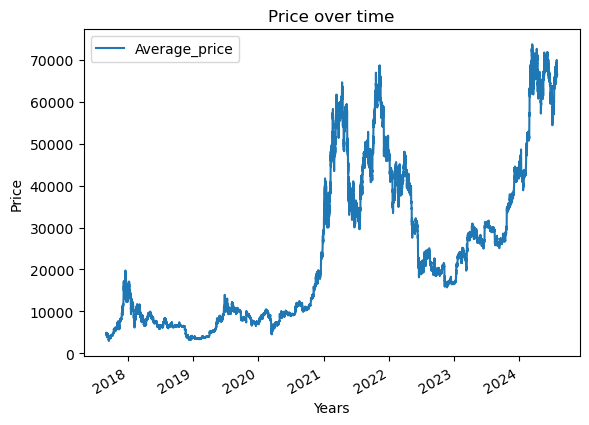

In [19]:
df.plot(y='Average_price')
plt.title('Price over time')
plt.ylabel('Price')
plt.xlabel('Years')

#Seems to be large uptrend season/cycle ever 3

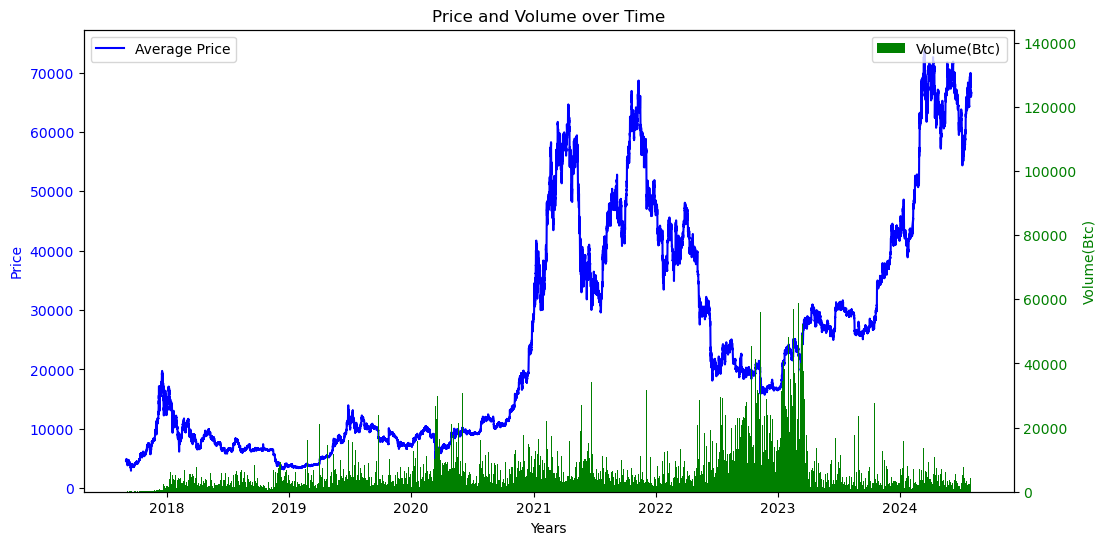

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the size as needed

# Plot the Average_price on the first y-axis
ax1.plot(df.index, df['Average_price'], color='blue', label='Average Price')
ax1.set_xlabel('Years')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume(Btc)'], color='green', label='Volume(Btc)')
ax2.set_ylabel('Volume(Btc)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Price and Volume over Time')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()




### 
- Volume spikes before a big move(either direction)
- Volume spikes incredibly high more than 120,000 indicating fear, no similar spike(of same magnitude) for when market bullish, shows that fear>greed
- Sideways price action tends to have lower volume
- Volume lower in bear market(increases rapidly at the end of it)
- Volume has barely or zero correlation with price (linearly speaking)

### Detecting Whale Activity Through Volume to No. Trade Ratio

Looking solely at the number of trades is not much more insightful than volume, as they are highly correlated, i.e., the more volume, the more trades should occur, and vice versa.

To gain more insight into market behavior, particularly the activities of different socio-economic groups or large entities ("whales"), we can analyze the ratio of volume in (USDT) to the number of trades. This metric can help identify instances where large volumes are being traded in fewer transactions, which might indicate the presence of whales or other significant market players.

#### Volume to Trade Ratio Equation

**Volume to Trade Ratio = Volume(USDT) / Number of Trades**

- A higher ratio might indicate fewer trades with large volumes, suggesting potential whale activity.
- A lower ratio could imply many smaller trades, potentially reflecting retail investor activity.

By tracking this metric over time, we can identify changes in trading patterns from market participants.

However, we also have to account for inflation. The average inflation from 2017-2024 was around **3.32%**. Adjusting the volume figures for inflation ensures that we are comparing volumes in real terms, providing a more accurate picture of changes in market behaior over time.
or over time.

articipants.
rticipants.


In [23]:
#Adjusted for inflation
start = df.index.min()
df['hours_since_start'] = (df.index - start).total_seconds() / 3600
inflation_rate = 0.0332  
annual_hours = 365.25 * 24  # Average number of hours in a year
df['inflation_adjustment_factor'] = 1.032 ** (df['hours_since_start'] / annual_hours)

df['Adjusted_Volume']=df['Volume(USDT)']/df['inflation_adjustment_factor']
df['Adjusted_Volume_per_trade'] = df['Adjusted_Volume']/df['Number_Of_Trades']

In [24]:
df.drop(columns=['hours_since_start','inflation_adjustment_factor',	'Adjusted_Volume','Volume(USDT)','Number_Of_Trades'],axis=1,inplace=True)

In [25]:
df.corr()

,Volume(Btc),Average_price,Adjusted_Volume_per_trade
Volume(Btc),1.000000,-0.014570,0.051203
Average_price,-0.014570,1.000000,0.392175
Adjusted_Volume_per_trade,0.051203,0.392175,1.000000


- Right away we see the medium correlation with price, indicating that it could be a  important metric for predicting price
- There is some correlation between "Whale" activity or higher amount trade with increase in price

## Time Series Modeling

In [28]:
#Price only
df_price = df[['Average_price']].reset_index()
X = df_price['timestamp']
y = df_price['Average_price']

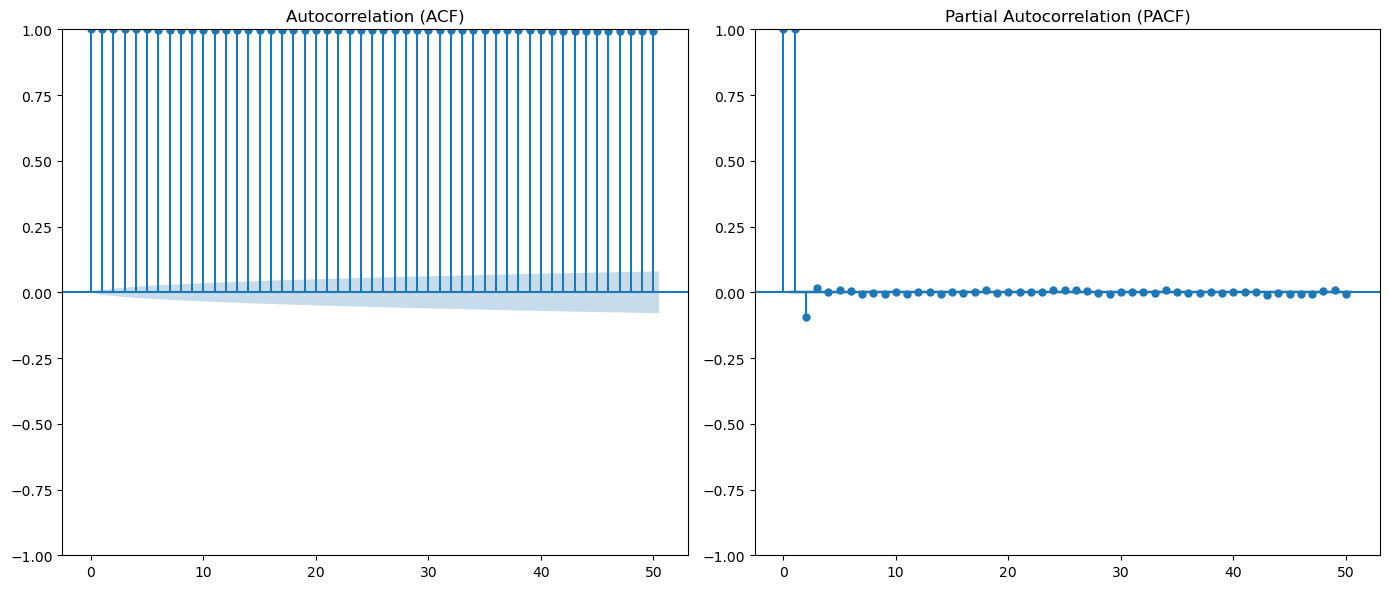

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ACF on the first subplot
plot_acf(y, lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')

# Plot PACF on the second subplot
plot_pacf(y, lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')

# Display the plots
plt.tight_layout()  
plt.show()

#Clearly data is non-stationary

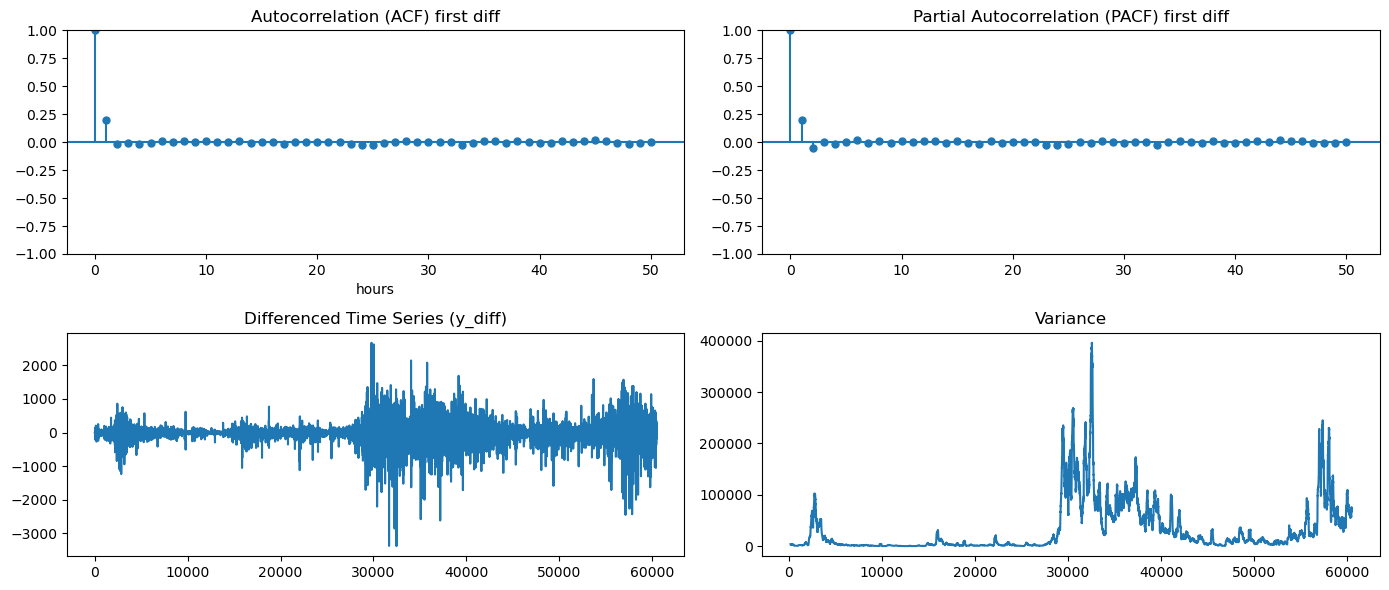

ADF Statistic: -31.558318562152028
p-value: 0.0


In [30]:
# Lets try 1 difference 
from statsmodels.tsa.stattools import adfuller

y_diff = y.diff().dropna()
plt.show()

rolling_var = y_diff.rolling(window=200).var()
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

plot_acf(y_diff, lags=50, ax=axes[0,0])
axes[0,0].set_title('Autocorrelation (ACF) first diff')
axes[0,0].set_xlabel('hours')



# Plot PACF on the second subplot
plot_pacf(y_diff, lags=50, ax=axes[0,1])
axes[0,1].set_title('Partial Autocorrelation (PACF) first diff')
axes[0,0].set_xlabel('hours')


axes[1,0].plot(y_diff)
axes[1,0].set_title('Differenced Time Series (y_diff)')

axes[1,1].plot(rolling_var)
axes[1,1].set_title('Variance')

# Display the plots
plt.tight_layout()  
plt.show()



adf_result = adfuller(y_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])



- Eventhough ADF stastistic and p-value are indicating the data is stationary we can clearly see this is not the case
- A constant variance should be observed, but clearly we can a spike around the middle
- Can't do log transform as variance is not increasing over time
- Let's try another differencing

In [32]:
#Auto correlation plot


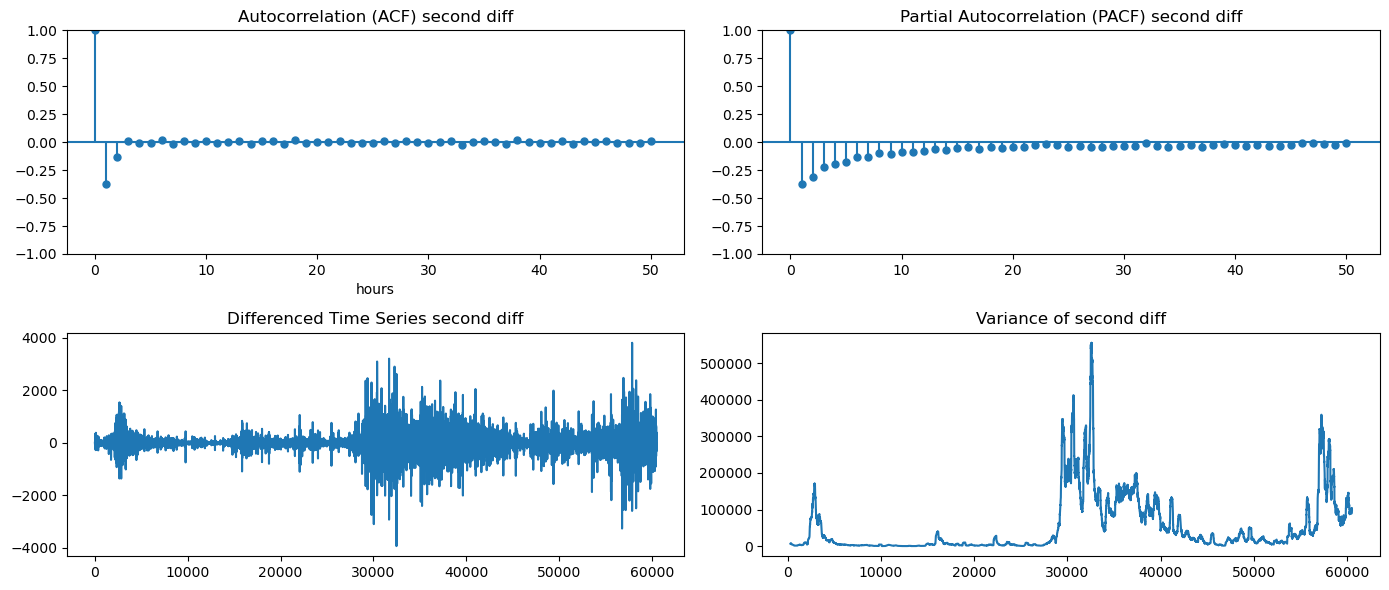

ADF Statistic: -56.10491833896103
p-value: 0.0


In [33]:
from statsmodels.tsa.stattools import adfuller

y_diff_diff = y.diff().diff().dropna()
plt.show()

rolling_var = y_diff_diff.rolling(window=300).var()
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

plot_acf(y_diff_diff, lags=50, ax=axes[0,0])
axes[0,0].set_title('Autocorrelation (ACF) second diff')
axes[0,0].set_xlabel('hours')



# Plot PACF on the second subplot
plot_pacf(y_diff_diff, lags=50, ax=axes[0,1])
axes[0,1].set_title('Partial Autocorrelation (PACF) second diff')
axes[0,0].set_xlabel('hours')


axes[1,0].plot(y_diff_diff)
axes[1,0].set_title('Differenced Time Series second diff')

axes[1,1].plot(rolling_var)
axes[1,1].set_title('Variance of second diff')

# Display the plots
plt.tight_layout()  
plt.show()



adf_result = adfuller(y_diff_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


- Now we can see that not much has changed on the variance or the plot of the second diff time series
- However we can see from PACF plot that many values are negative know(they were close to zero before) this is suggesting over-differencing
- If one differencing is not enough and two is over differencing this means ARIMA model is not suited for this
- We know they are cycles in the crypto market, hence we could possibly model it if we account for seasons, hence let's try SARIMA



## SARIMA

- We know Bitcoin's cycle is roughly how long every halving is or roughly 3-4 years as seen by the graph of prices
- Using hourly data will not be able viable to spot this due too much noise
- Hence to spot these long terms we will use weekly data

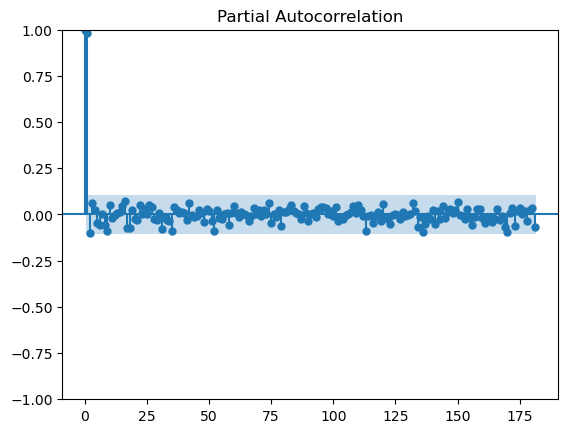

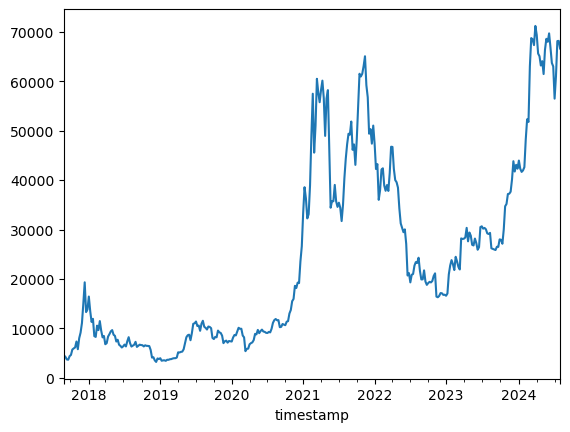

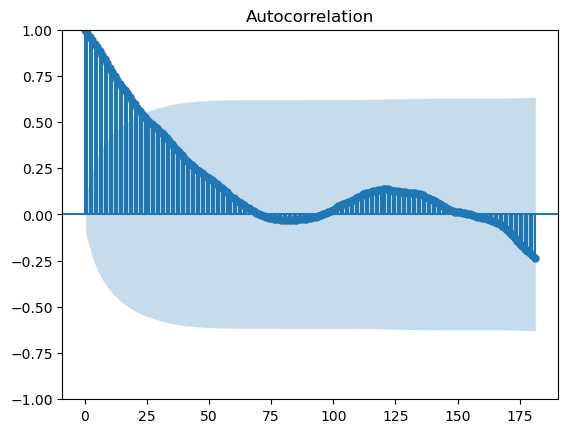

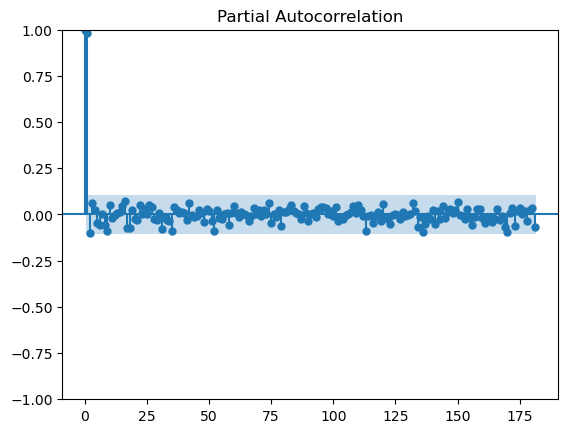

In [37]:
df_daily=df.resample('D').last()['Average_price']

df_weekly=df.resample('W').last()['Average_price']
df_weekly.plot()

plot_acf(df_weekly,lags=181)
plot_pacf(df_weekly,lags=181)

#Hard to spot this cycle let's try another way to visualise

C:\Users\hp\AppData\Local\Temp\ipykernel_18336\3909306267.py:5: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


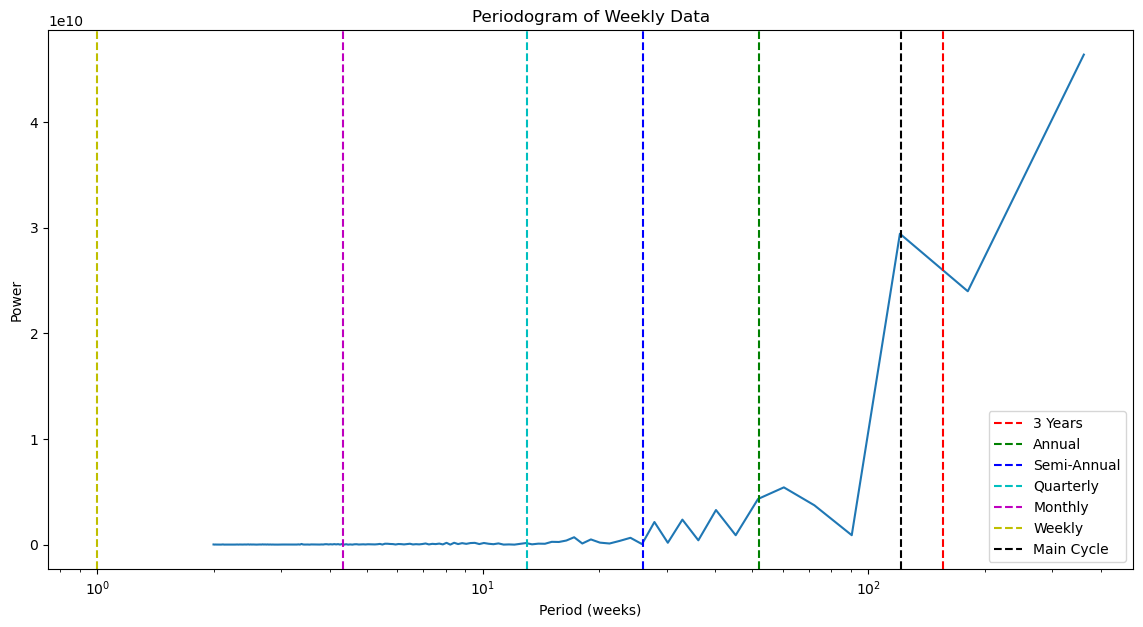

In [38]:
from scipy.signal import periodogram
frequencies, power = periodogram(df_weekly, fs=1)  # fs=1 because it's weekly data

# Convert frequencies to periods (in weeks)
periods = 1 / frequencies

# Define the specific periods you're interested in (in weeks)
three_years = 3 * 52  # Three years in weeks
annual = 52           # Annual cycle in weeks
semi_annual = 26      # Semi-annual cycle in weeks
quarterly = 13        # Quarterly cycle in weeks
monthly = 4.33        # Monthly cycle in weeks (approximately)
weekly = 1            # Weekly cycle
main_cycle = 2.33*52
# Plot the periodogram with marked periods
plt.figure(figsize=(14, 7))
plt.plot(periods, power)
plt.xscale('log')
plt.title('Periodogram of Weekly Data')
plt.xlabel('Period (weeks)')
plt.ylabel('Power')
plt.axvline(three_years, color='r', linestyle='--', label='3 Years')
plt.axvline(annual, color='g', linestyle='--', label='Annual')
plt.axvline(semi_annual, color='b', linestyle='--', label='Semi-Annual')
plt.axvline(quarterly, color='c', linestyle='--', label='Quarterly')
plt.axvline(monthly, color='m', linestyle='--', label='Monthly')
plt.axvline(weekly, color='y', linestyle='--', label='Weekly')
plt.axvline(main_cycle, color='black', linestyle='--', label='Main Cycle')

plt.legend()
plt.show()

- We can see a peak slightly less than 3 years (This will be the main cycle used to model the SARIMA model) around 2 years and 4 months
- However bitcoin cycle lenght is roughly 3 years and 9 months, but we dont have enough data, as the current cycle is not over yet(which could distort results for a cycle at a lower time frame that what it should be)
- Hence we shall try both cycle lenghts


In [40]:
# If we look at the time between the last cycle peaks
from dateutil.relativedelta import relativedelta

df_first_cycle = df_weekly[df_weekly.index<'01-01-2019'].to_frame()
first_max = df_first_cycle[df_first_cycle['Average_price'] == df_first_cycle['Average_price'].max()].index

df_second_cycle = df_weekly[('01-01-2019'<df_weekly.index) & (df_weekly.index<'01-03-2022')].to_frame()
second_max = df_second_cycle[df_second_cycle['Average_price'] == df_second_cycle['Average_price'].max()].index

difference = relativedelta(second_max[0], first_max[0])

print(f"Difference: {difference.years} years, {difference.months} months, {difference.days} days") #Very close to known cycle lenght

#Roughly 47 months



Difference: 3 years, 10 months, 28 days


In [41]:
#SARIMA could not handle weekly or daily data too much...
df_monthly = df.resample('ME').last()['Average_price']


split_index = int(len(df_monthly) * 0.8)

train_data = df_monthly.iloc[:split_index]
test_data = df_monthly.iloc[split_index:]

train_data

timestamp
2017-08-31     4711.945
2017-09-30     4369.975
2017-10-31     6443.995
2017-11-30     9909.050
2017-12-31    13829.980
                ...    
2022-10-31    20502.605
2022-11-30    17187.760
2022-12-31    16535.760
2023-01-31    23185.255
2023-02-28    23180.215
Freq: ME, Name: Average_price, Length: 67, dtype: float64

In [42]:
import pmdarima as pm
model = pm.auto_arima(train_data,
                      seasonal=True,
                      m=46,  # Specify the seasonal period (e.g., monthly seasonality)
                      stepwise=True,  # Stepwise search to reduce computation time
                      trace=True)  # Print the model details

# Print the summary of the model
print(model.summary())

C:\Users\hp\anaconda3\Lib\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (21) is shorter than m (46). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[46]             : AIC=inf, Time=3.23 sec
 ARIMA(0,1,0)(0,1,0)[46]             : AIC=408.733, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[46]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[46]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[46]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[46]             : AIC=410.012, Time=0.27 sec
 ARIMA(0,1,0)(1,1,1)[46]             : AIC=411.898, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[46]             : AIC=410.552, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[46]             : AIC=410.748, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[46]             : AIC=411.997, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[46] intercept   : AIC=410.472, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[46]          
Total fit time: 5.230 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:         

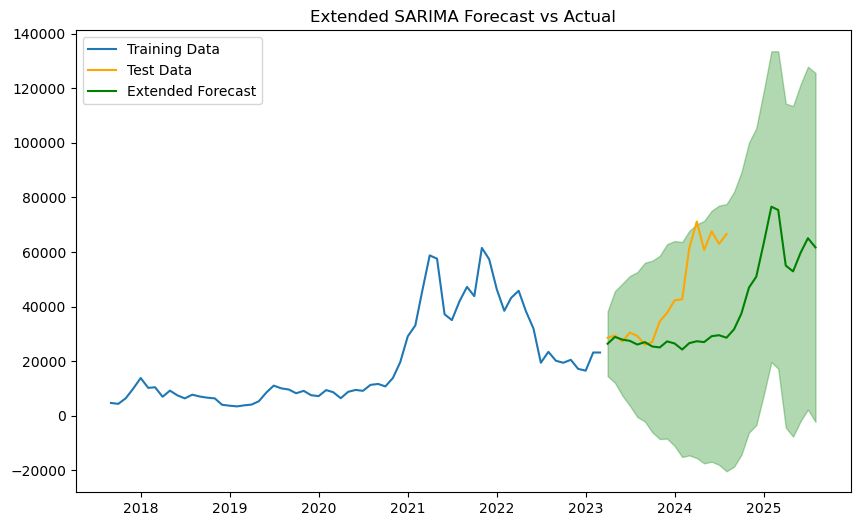

Root Mean Squared Error: 23170.032903720075
Mean Absolute Error: 16971.827058823532


In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error


# Set the forecast horizon (e.g., forecast 12 periods beyond the test data)
extended_n_periods = len(test_data) + 12

# Generate the forecast and confidence intervals
extended_forecast, extended_conf_int = model.predict(n_periods=extended_n_periods, return_conf_int=True)

# Create a new forecast DataFrame for easier handling
extended_forecast_index = pd.date_range(start=test_data.index[0], periods=extended_n_periods, freq=test_data.index.freq)
extended_forecast_df = pd.DataFrame(extended_forecast, index=extended_forecast_index, columns=['Forecast'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(extended_forecast_df.index, extended_forecast_df['Forecast'], label='Extended Forecast', color='green')
plt.fill_between(extended_forecast_df.index, extended_conf_int[:, 0], extended_conf_int[:, 1], color='green', alpha=0.3)
plt.legend(loc='upper left')
plt.title('Extended SARIMA Forecast vs Actual')
plt.show()


mse = mean_squared_error(test_data, extended_forecast[:len(test_data)])
print(f'Root Mean Squared Error: {mse**(1/2)}')
mae = mean_absolute_error(test_data, extended_forecast[:len(test_data)])
print(f'Mean Absolute Error: {mae}')

# A horrible errors


- SARIMA lags too much and highly inaccurate(even when tuning the seasonal_periods)
-  This could be due to insufficent data(using monthly data)
-  Had to use monthly data due to weekly and daily data was too much for SARIMA to handle
-  Too complex seasons for SARIMA to handle

# Prophet

In [46]:
from prophet import Prophet
df_daily
df

,Volume(Btc),Average_price,Adjusted_Volume_per_trade
timestamp,,,
2017-08-31 17:00:00,7.159727,4684.980,315.350091
2017-08-31 18:00:00,18.489213,4700.675,538.705842
2017-08-31 19:00:00,24.883439,4724.220,687.695389
2017-08-31 20:00:00,13.148827,4702.945,650.420373
2017-08-31 21:00:00,16.740692,4705.105,595.335511
...,...,...,...
2024-07-31 13:00:00,1327.058830,66501.530,753.788815
2024-07-31 14:00:00,1822.664590,66620.515,908.602734
2024-07-31 15:00:00,663.878160,66500.010,655.086024


In [47]:
df_hourly = df.reset_index()[['timestamp','Average_price']]

In [48]:
df_hourly_for_test = df_hourly.rename(columns = {'timestamp':'ds','Average_price':'y'})
split_idx = int(len(df_hourly_for_test) * 0.9)
train_data = df_hourly_for_test[:split_idx]
test_data = df_hourly_for_test[split_idx:]

In [49]:
%%time
model = Prophet(yearly_seasonality=True)
period_hours = 46* 30.5 *24  
model.add_seasonality(name='three_years_ten_months', period=period_hours, fourier_order=10)
model.fit(train_data)

21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 2.16 s
Wall time: 2min 8s


C:\Users\hp\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\hp\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


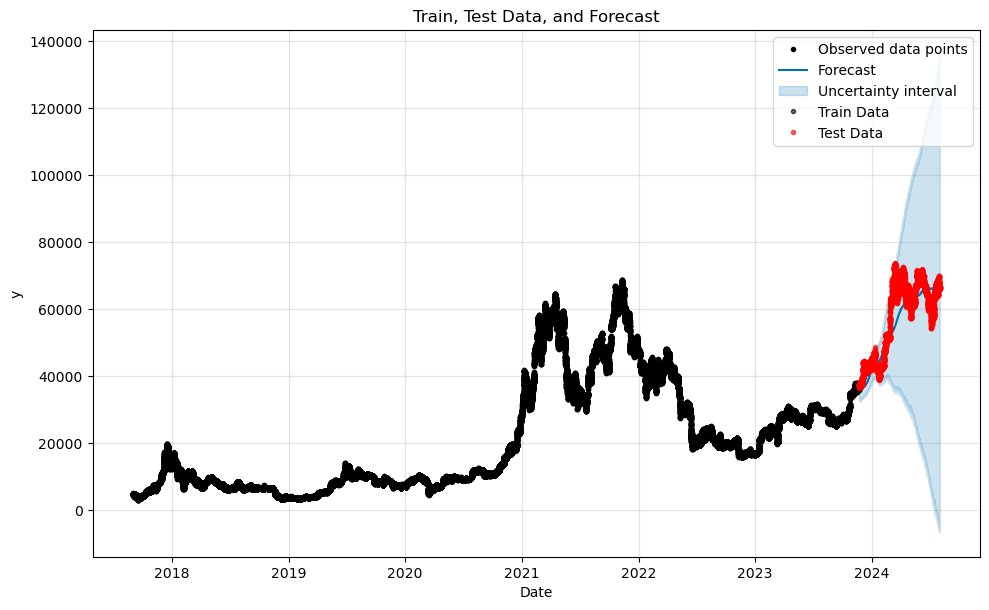

In [50]:
# Plot the forecast first
forecast = model.predict(test_data)

fig = model.plot(forecast)

# Get the underlying axes from the figure
ax = fig.gca()

# Plot the training data with lower opacity
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Train Data', alpha=0.6)

# Plot the test data with lower opacity
ax.plot(test_data['ds'], test_data['y'], 'r.', label='Test Data', alpha=0.6)

# Customize the legend and labels
ax.legend()
ax.set_title('Train, Test Data, and Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('y')

# Show the plot
plt.show()


In [51]:
MSE = mean_squared_error(forecast['yhat'],test_data['y'])**(1/2)
MAE = mean_absolute_error (forecast['yhat'],test_data['y'])

print(f"MSE is {MSE} and MAE is {MAE}")
# Much better than SARIMA

MSE is 5796.224719502303 and MAE is 4385.749014781628


In [52]:
test_data_hourly = test_data[['ds']]

last_date = test_data_hourly['ds'].max()

new_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), 
                          periods=365 * 24,  # 1 year of hourly data
                          freq='h')  # Use 'h' instead of 'H' based on the warning

new_dates_df = pd.DataFrame(new_dates, columns=['ds'])

extended_test_data_hourly = pd.concat([test_data_hourly, new_dates_df], ignore_index=True)


C:\Users\hp\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\hp\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


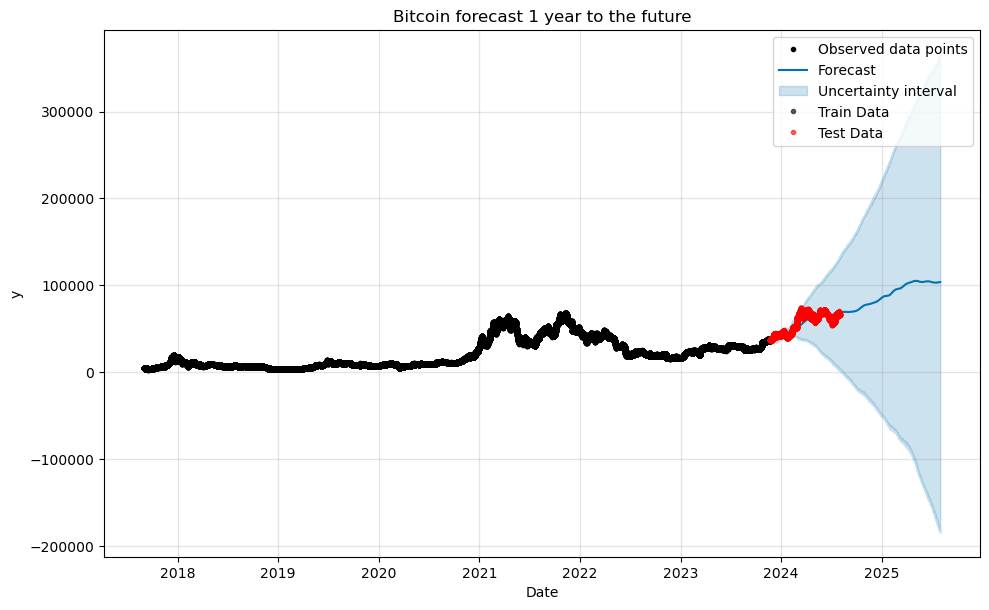

In [53]:
forecast = model.predict(extended_test_data_hourly)

fig = model.plot(forecast)

ax = fig.gca()

ax.plot(train_data['ds'], train_data['y'], 'k.', label='Train Data', alpha=0.6)

ax.plot(test_data['ds'], test_data['y'], 'r.', label='Test Data', alpha=0.6)

# Customize the legend and labels
ax.legend()
ax.set_title('Bitcoin forecast 1 year to the future')
ax.set_xlabel('Date')
ax.set_ylabel('y')

# Show the plot
plt.show()


In [54]:
extended_test_data_hourly

,ds
0,2023-11-22 16:00:00
1,2023-11-22 17:00:00
2,2023-11-22 18:00:00
3,2023-11-22 19:00:00
4,2023-11-22 20:00:00
...,...
14805,2025-07-31 13:00:00
14806,2025-07-31 14:00:00
14807,2025-07-31 15:00:00
14808,2025-07-31 16:00:00


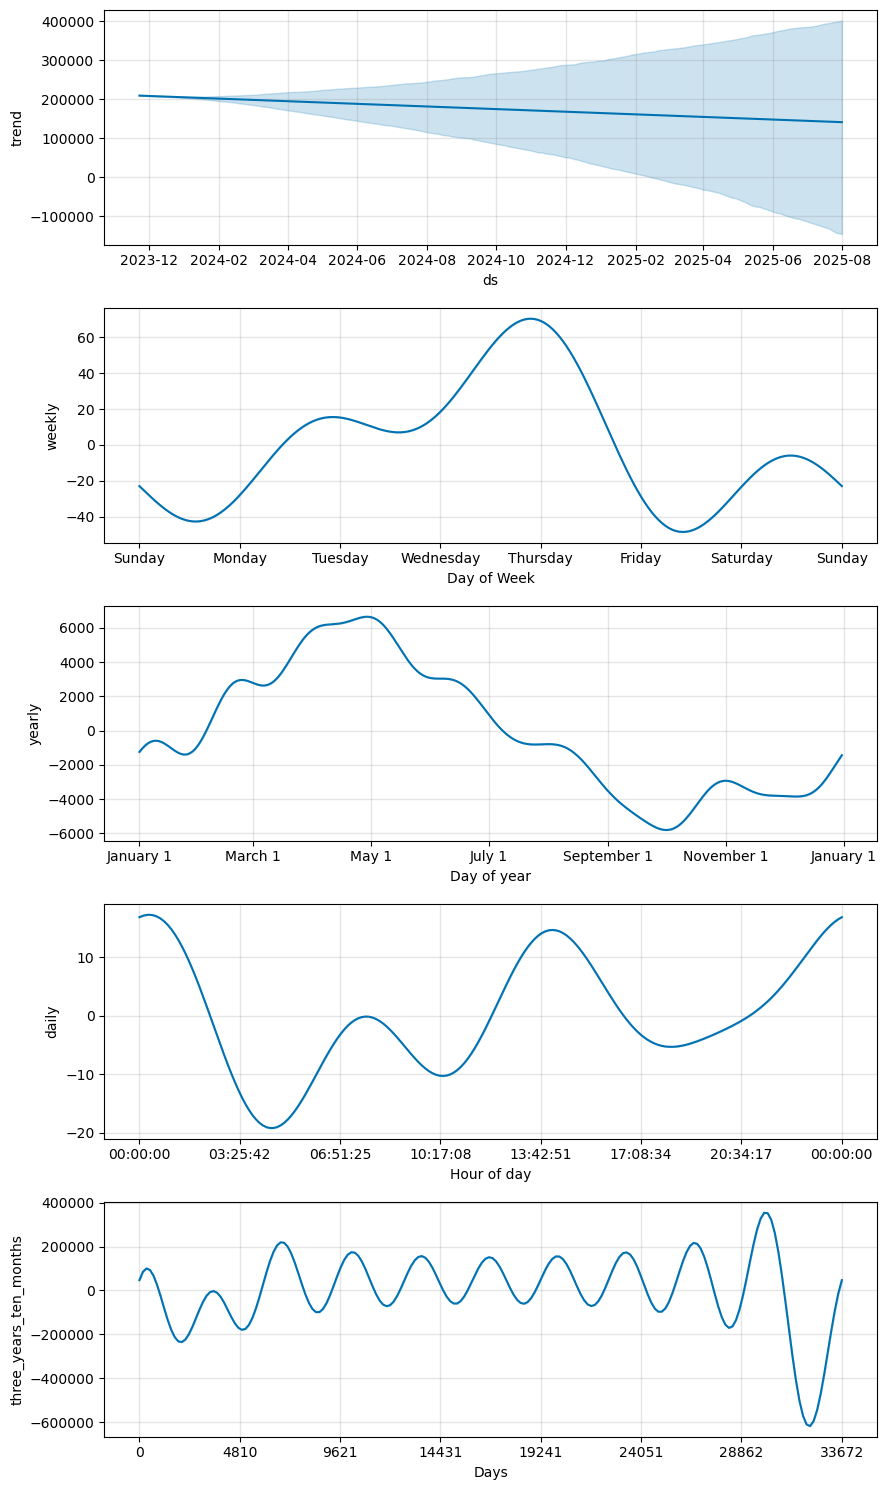

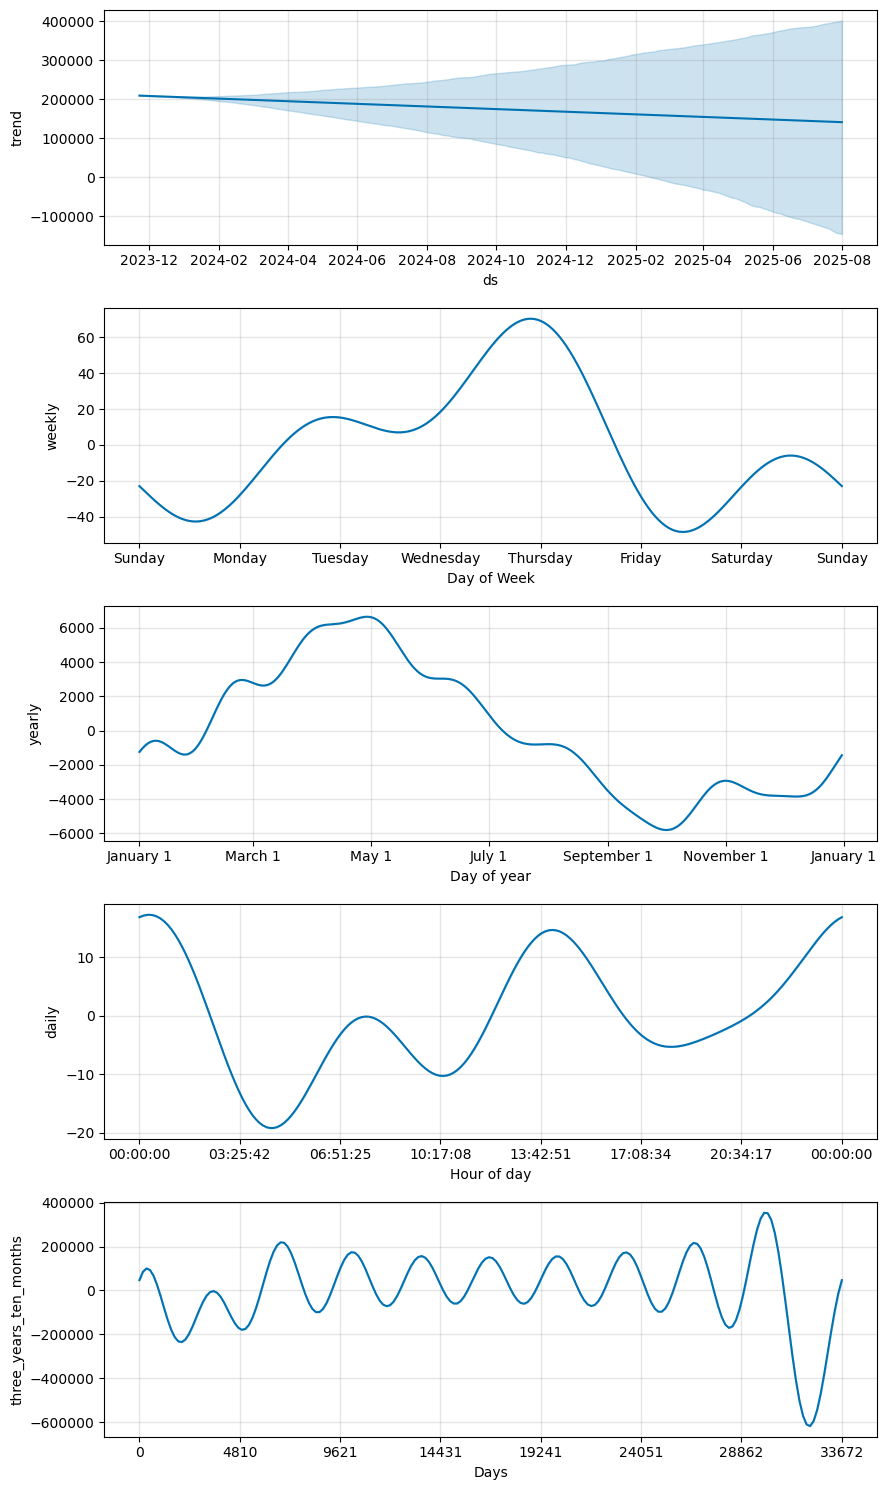

In [55]:
import warnings
warnings.filterwarnings("ignore")
model.plot_components(forecast)


# Intresting insights gained
- Thursday seens to be the day when prices go up
- Weekneds tend to have lower price action(this is well known from trading bitcoin)
 - Q4 performs worst than Q1 and Q2 